### テキストの感情分類
- Google Colaboratoryにて実行。
- 文章の感情分類を以下要領で実施。
    - 事前学習モデルを利用し、公開データセット（アノテーション済み）でファインチューニング
        - [データセット](https://huggingface.co/datasets)
    - 予測対象データ（スクレイピングで取得し、手動でアノテーションを行ったデータ）で感情分類を行い、精度を評価。

- ローカルで行う場合、以下を事前に入れておくこと
```
conda install -c conda-forge datasets
conda insdtall -c conda-forge transformers
pip install fugashi
pip install ipadic
```

- 参考
    - [Hugging Faceを使って事前学習モデルを日本語の感情分析用にファインチューニングしてみた](https://dev.classmethod.jp/articles/huggingface-jp-text-classification/)

In [ ]:
# インストール
!pip install transformers
!pip install torch
!pip install accelerate -U
!pip install datasets
!pip install fugashi
!pip install ipadic


In [ ]:
# import
import os
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix


In [ ]:
# データセットのロード
dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese")

# データセットの確認
dataset


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
                                                text     label  \
0  普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しか...  negative   
1  十分な在庫を用意できない販売元も悪いですが、Amazonやら楽⚪︎が転売を認めちゃってるのが...  negative   
2  見た目はかなりおしゃれで気に入りました。2、3回持ち歩いた後いつも通りゼンマイを巻いていたら...  negative   
3  よくある部分での断線はしませんでした ただiphoneとの接続部で接触不良、折れました ip...  negative   
4  プラモデルの塗装剥離に使う為に購入 届いて早速使ってみた 結果 １ヶ月経っても未だに剥離出来...  negative   

                 source  
0  amazon_reviews_multi  
1  amazon_reviews_multi  
2  amazon_reviews_multi  
3  amazon_reviews_multi  
4  amazon_reviews_multi  
----------------------------------------------------------------------------------------------------


Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
                                                text     label  \
0  味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５本のうち２本が蒸気も出ず、吸い込...  negative   
1             ホームボタン周りの気泡が全く抜けません。 返金をお願いしましたが、断られた。  negative   
2  新旧含めて4つのカーテンレールがあるのですが、使用出来るカーテンレールはありませんでした。 ...  negative   
3            予約注文でしたが、どこから特典であるpdfダウンロードすればよいのでしょうか…  negative   
4  前のレビューにもありましたが、片方が全く動きません。 返品しようにも、なんだかめんどくさいし...  negative   

                 source  
0  amazon_reviews_multi  
1  amazon_reviews_multi  
2  amazon_reviews_multi  
3  amazon_reviews_multi  
4  amazon_reviews_multi  
----------------------------------------------------------------------------------------------------


Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
                                                text     label  \
0  購入、貼付け後2週間もたたないうちに、上側から剥がれてきて画面から浮いた状態になってしまった...  negative   
1  以下の3点の理由により、期待はずれの粗悪品。 ①他の方のレビューにもある通り、天板の外観が掲...  negative   
2  この商品の内容等確認した購入したのですが、そのとおりなかなか設定ができなく、知人にもお願いし...  negative   
3  テストした結果、4000mahのスマホ一回と30％分、スマホのバッテリー残量の表示が正しけれ...  negative   
4  前回の黒いドレッサーバッグの評判がよかったため、予約して購入しました。 ガッカリです。 ヨレ...  negative   

                 source  
0  amazon_reviews_multi  
1  amazon_reviews_multi  
2  amazon_reviews_multi  
3  amazon_reviews_multi  
4  amazon_reviews_multi  
----------------------------------------------------------------------------------------------------


DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
})

In [ ]:
# フォーマットを指定し、データフレームとして読み込む
dataset.set_format(type="pandas")
train_df = dataset["train"][:]
validation_df = dataset["validation"][:]
test_df = dataset["test"][:]

# source列とlabel列の値の内訳を確認
print(f'train_df.value_counts(["source", "label"]):\n{train_df.value_counts(["source", "label"])}')
print(f'validation_df.value_counts(["source", "label"]):\n{validation_df.value_counts(["source", "label"])}')
print(f'test_df.value_counts(["source", "label"]):\n{test_df.value_counts(["source", "label"])}')

# テーブル構造を確認
print(f'train:\n{dataset["train"].features}')
print(f'validation:\n{dataset["validation"].features}')
print(f'test:\n{dataset["test"].features}')


train_df.value_counts(["source", "label"]):
source                label
amazon_reviews_multi  0        40000
                      1        40000
                      2        40000
dtype: int64
validation_df.value_counts(["source", "label"]):
source                label
amazon_reviews_multi  0        1000
                      1        1000
                      2        1000
dtype: int64
test_df.value_counts(["source", "label"]):
source                label
amazon_reviews_multi  0        1000
                      1        1000
                      2        1000
dtype: int64
train:
{'text': Value(dtype='string', id=None), 'source': Value(dtype='string', id=None), 'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None)}
validation:
{'text': Value(dtype='string', id=None), 'source': Value(dtype='string', id=None), 'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None)}
test:
{'text': Value(dtype='string', id=None), 'source': Value(dtype='string', id=N

In [ ]:
def label_int2str(x, dataset_name):
    """
    整数ラベルを文字列ラベルに変換する関数
    Args:
        x (int): 変換する整数ラベル
        dataset_name (str): データセット名
    Returns:
        str: 文字列ラベル
    変数datasetが宣言済みの部分で実行しないとエラーになる。
    """
    return dataset[dataset_name].features["label"].int2str(x)

train_df["label_name"] = train_df["label"].apply(label_int2str, dataset_name="train")
validation_df["label_name"] = validation_df["label"].apply(label_int2str, dataset_name="validation")
test_df["label_name"] = test_df["label"].apply(label_int2str, dataset_name="test")


In [ ]:
# データフレームにしていたフォーマットをデフォルトに戻す
dataset.reset_format()


### モデルのロード・データセットのトークン化
- [こちら](https://huggingface.co/models)から日本語のBERTモデルを探索し、タスクとダウンロード数を基に選定
- 以下のトークナイザの動作確認でトークン化がうまくできているか確認した上で使うのが無難。

- 備考
    - input_ids: 数字にエンコードされたトークン。
    - attention_mask: 後段のモデルで有効なトークンかどうかを判別するためのマスク。無効なトークン（例えば、[PAD]など）に対しては、attention_maskを0として処理。
    - トークナイザの結果は数字にエンコードされているため、トークン文字列を得るには、convert_ids_to_tokensを用いる。

In [ ]:
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [ ]:
# トークナイザの動作確認用
sample_text = "\
機械学習のコア部分のロジックを、定型的な実装部分から切り離して\
定義できるようなインターフェースに工夫されています。 \
そのためユーザーは、機械学習のコア部分のロジックの検討に\
集中することができます。\
"

# トークン化
sample_text_encoded = tokenizer(sample_text)
print(f"数値にエンコードされたトークン：\n{sample_text_encoded}")

# トークン文字列の確認
tokens = tokenizer.convert_ids_to_tokens(sample_text_encoded.input_ids)
print(tokens)

# トークン文字列の再構成
decode_text = tokenizer.convert_tokens_to_string(tokens)
print(decode_text)

# モデルが対応する最大のコンテキストサイズ
print(f"モデルが対応する最大のコンテキストサイズ: {tokenizer.model_max_length}")


数値にエンコードされたトークン：
{'input_ids': [2, 2943, 4293, 5, 6759, 972, 5, 138, 17394, 11, 6, 23398, 81, 18, 6561, 972, 40, 24547, 16, 2279, 392, 124, 18, 23953, 7, 9909, 26, 20, 16, 21, 2610, 8, 59, 82, 4502, 9, 6, 2943, 4293, 5, 6759, 972, 5, 138, 17394, 5, 3249, 7, 4155, 34, 45, 14, 203, 2610, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', '機械', '学習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'を', '、', '定型', '的', 'な', '実装', '部分', 'から', '切り離し', 'て', '定義', 'できる', 'よう', 'な', 'インターフェース', 'に', '工夫', 'さ', 'れ', 'て', 'い', 'ます', '。', 'その', 'ため', 'ユーザー', 'は', '、', '機械', '学習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'の', '検討', 'に', '集中', 'する', 'こと', 'が', 'でき', 'ます', '。', '[S

In [ ]:
def tokenize(batch):
    """
    データセットのトークン化
    Args:
        batch (_type_): _description_
    Returns:
        _type_: _description_
    """
    return tokenizer(
        batch["text"],
        padding=True, # バッチ内の最も長い系列長に合うようpaddingする処理を有効化
        truncation=True # 後段のモデルが対応する最大コンテキストサイズ以上を切り捨て
    )

# データセット全体
dataset_encoded = dataset.map(
    tokenize,
    batched=True, # バッチ化
    batch_size=None # 全体が1バッチとなる
)

# 結果の確認
dataset_encoded


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})

In [ ]:
# サンプル単位で確認するには下記を実行
import pandas as pd
sample_encoded = dataset_encoded["train"][0]
pd.DataFrame(
    [sample_encoded["input_ids"]
     , sample_encoded["attention_mask"]
     , tokenizer.convert_ids_to_tokens(sample_encoded["input_ids"])],
    ['input_ids', 'attention_mask', "tokens"]
).T


,input_ids,attention_mask,tokens
0,2,1,[CLS]
1,9406,1,普段
2,3276,1,使い
3,13,1,と
4,10602,1,バイク
...,...,...,...
507,0,0,[PAD]
508,0,0,[PAD]
509,0,0,[PAD]
510,0,0,[PAD]


### 分類器の実装と評価指標算出用のメソッド実装
分類器の実装は大きく2パターン。
- 接続した分類用ヘッドのみを学習<br>
    -> 高速な学習が可能でGPUなどが利用できない場合に選択肢となりうる
- BERTを含むモデル全体を学習(fine-tuning)<br>
    -> よりタスクに特化できるので高精度となる。

In [ ]:
# テキストを系列単位で分類するタスクには、既に専用のクラスが準備されており、以下で構築が可能
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3

model = (AutoModelForSequenceClassification
    .from_pretrained(model_name, num_labels=num_labels)
    .to(device))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(pred):
    """
    評価指標算出用の関数
    EvalPredictionオブジェクト（predictionsとlabel_idsという属性を持つnamed_tuple）をうけとる形で実装
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


### モデル学習用の設定と学習実行

In [ ]:
batch_size = 16
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = "text-classification-bert"

# 学習用のパラメータをTrainingArgumentsクラスを用いて設定
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)


In [ ]:
# 学習の実行
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.263900,0.557011,0.830667,0.829274,0.830667,0.829154
2,0.270700,0.509472,0.834000,0.832204,0.834000,0.832529


TrainOutput(global_step=15000, training_loss=0.2672864176432292, metrics={'train_runtime': 7347.0019, 'train_samples_per_second': 32.666, 'train_steps_per_second': 2.042, 'total_flos': 6.314722025472e+16, 'train_loss': 0.2672864176432292, 'epoch': 2.0})

### モデル保存・ロードして推論

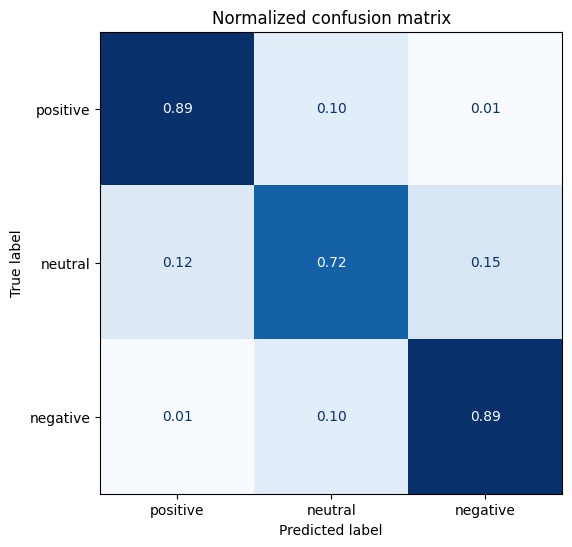

In [ ]:
# 検証データの推論
preds_output = trainer.predict(dataset_encoded["validation"])

# 検証データの推論結果を混同行列で可視化
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_encoded["validation"]["label"])
labels = dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)


In [ ]:
# モデルの保存
id2label = {}
for i in range(dataset["train"].features["label"].num_classes):
    id2label[i] = dataset["train"].features["label"].int2str(i)

label2id = {}
for i in range(dataset["train"].features["label"].num_classes):
    label2id[dataset["train"].features["label"].int2str(i)] = i

trainer.model.config.id2label = id2label
trainer.model.config.label2id = label2id

result_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/text_classification/"
os.makedirs(result_dir, exist_ok = True)
filename = model_name + "_fine_tuned"
trainer.save_model(result_dir + filename)


サンプルテキストの推論

In [ ]:
result_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/text_classification/"
filename = "text-classification-bert_fine-tuned"

# sample_text = "\
# 機械学習のコア部分のロジックを、定型的な実装部分から切り離して\
# 定義できるようなインターフェースに工夫されています。 \
# そのためユーザーは、機械学習のコア部分のロジックの検討に\
# 集中することができます。\
# "

sample_text = "\
  機械学習モデルに投入しさえすれば自動でうまい具合に予測してくれるというのはあまりにも楽観的である。\
  データの適切な前処理と予測後の評価指標・解釈こそが重要である。 \
  "


In [ ]:
# ロードして推論
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_tokenizer = AutoTokenizer\
    .from_pretrained(result_dir + filename)

new_model = (AutoModelForSequenceClassification
    .from_pretrained(result_dir + filename)
    .to(device))

# サンプルテキストのテスト推論
inputs = new_tokenizer(sample_text, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device),
        inputs["attention_mask"].to(device),
    )
outputs.logits


tensor([[-1.5410,  0.2451,  1.0600]], device='cuda:0')

In [ ]:
# logitsから確率に変換
probabilities = F.softmax(outputs.logits, dim=1)[0].cpu().numpy().tolist()
probabilities = [round(prob, 5) for prob in probabilities]
probabilities


[0.04892, 0.29184, 0.65925]

In [ ]:
# logitsを推論ラベルに変換
# y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().tolist(), axis=1)
def id2label(x):
    return new_model.config.id2label[x]
y_dash = [id2label(x) for x in y_preds]
y_dash


['negative']

In [ ]:
np.argmax(outputs.logits.to('cpu').detach(), axis=1).tolist()[0]


2

In [ ]:
outputs.logits.to('cpu').detach().numpy()


array([[-1.5409728,  0.245094 ,  1.0600015]], dtype=float32)